In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [123]:
df = pd.read_csv('data/only2_big_with_sf.csv')
df.set_index('cell_line', inplace=True)
df.head()

,7105,8813,57147,55732,2268,3075,2519,2729,4800,90529,...,8336,84311,126661,79447,283521,29122,9997,388963,6905,SF
cell_line,,,,,,,,,,,,,,,,,,,,,
NCIH1568-2,5.626439,6.855242,2.185867,4.079805,0.084064,0.176323,6.824513,4.956521,3.766595,2.298658,...,0.622930,5.373996,1.956057,5.482203,0.422233,0.176323,0.918386,1.778209,4.050502,0.607940
SCC9-2,3.964399,5.718088,2.260026,3.451541,0.084064,0.782409,6.039796,5.778734,4.903038,2.711495,...,1.536053,5.042207,2.344828,3.937344,0.000000,0.042644,2.475085,1.176323,4.174726,0.573035
HCC1428-2,4.002703,5.870365,3.621759,3.861955,0.014355,0.485427,4.614121,5.286881,4.429616,3.442280,...,3.033863,4.539159,1.970854,5.895303,0.622930,0.014355,0.918386,2.244887,5.555816,0.450188
U2OS-2,5.098453,6.543496,2.117695,4.115200,0.014355,0.432959,5.684258,4.847997,5.108524,2.189034,...,0.176323,5.028569,2.967169,4.995937,0.111031,0.042644,2.010780,1.925999,4.635754,0.526517
LU99-2,3.665620,6.716717,2.100978,4.176323,0.000000,1.263034,6.124948,4.395063,5.070389,2.669027,...,1.321928,6.613679,1.438293,4.349082,0.000000,0.111031,1.111031,1.632268,5.197315,0.625161


In [87]:
# Create a copy for further processing
dataset = df.copy()
# Get some basic data about dataset
print(len(dataset))

525


In [88]:
# Split the Dataset and create train and test sets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
########################################################
# Separate labels and features
train_features = train_dataset.drop(["SF"], axis=1)
test_features = test_dataset.drop(["SF"], axis=1)
train_labels = train_dataset["SF"]
test_labels = test_dataset["SF"]

In [89]:
# Let's check some basic data about dataset
# train_dataset.describe().transpose()

In [90]:
# But we can also apply normalization using sklearn.
from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()
label_scaler = StandardScaler()
########################################################
# Fit on Training Data
feature_scaler.fit(train_features.values)
label_scaler.fit(train_labels.values.reshape(-1, 1))
########################################################
# Transform both training and testing data
train_features = feature_scaler.transform(train_features.values)
test_features = feature_scaler.transform(test_features.values)
train_labels = label_scaler.transform(train_labels.values.reshape(-1, 1))
test_labels = label_scaler.transform(test_labels.values.reshape(-1, 1))

In [91]:
# Now let's create a Deep Neural Network to train a regression model on our data.
model = Sequential([
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [92]:
# Compile the model
model.compile(optimizer="Adam",
              loss="mean_absolute_error")

In [111]:
# Now let's train the model
history = model.fit(epochs=200, x=train_features, y=train_labels,
          validation_data=(test_features, test_labels), verbose=0)

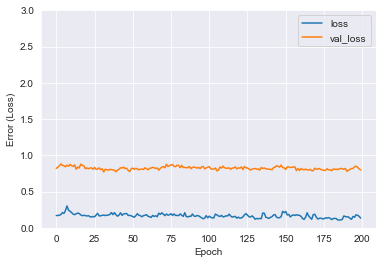

In [112]:
# Function to plot loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0,3])
    plt.xlabel('Epoch')
    plt.ylabel('Error (Loss)')
    plt.legend()
    plt.grid(True)
########################################################
plot_loss(history)

In [113]:
# Model evaluation on testing dataset
model.evaluate(test_features, test_labels)

4/4 [==============================] - 0s 0s/step - loss: 0.7968


0.7968010902404785

In [114]:
# Save model
model.save("data/trained_model_tf_regression.h5")

In [115]:
# Load and perform predictions
saved_model = tf.keras.models.load_model('data/trained_model_tf_regression.h5')
results = saved_model.predict(test_features)
########################################################
# We can decode using the scikit-learn object to get the result
decoded_result = label_scaler.inverse_transform(results.reshape(-1,1))
# print(decoded_result)

4/4 [==============================] - 0s 3ms/step


In [116]:
decoded_labels = label_scaler.inverse_transform(test_labels.reshape(-1,1))
# print(decoded_labels.tolist())

In [117]:
label_list = []
pred_list = []
for i in range(len(decoded_result)):
    label_list.append(decoded_labels[i][0])
    pred_list.append(decoded_result[i][0])
    # print("Predicted: ", decoded_result[i], " Actual: ", decoded_labels[i])

In [118]:
# print(label_list)
# print(pred_list)

Slope: 0.11994903093302135
Intercept: 0.5311160685574741
R-Squared: 0.09046735216088997
P-Value: 0.001822745376608491
Standard Error: 0.03747497380905567


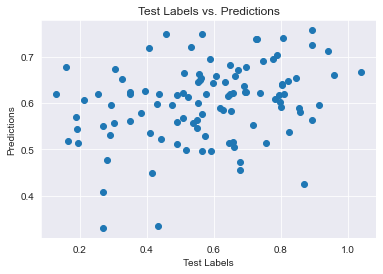

In [119]:
import scipy.stats as stats
X_var = label_list
y_var = pred_list
plt.plot(X_var, y_var, 'o')
slope, intercept, r_value, p_value, std_err = stats.linregress(X_var, y_var)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-Squared:", r_value**2)
print("P-Value:", p_value)
print("Standard Error:", std_err)
plt.xlabel('Test Labels')
plt.ylabel('Predictions')
plt.title('Test Labels vs. Predictions')
plt.show()